## Image Deblurring Project


## Import packages and locate to dataset for training

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import os
os.chdir('/content/drive/MyDrive/Capstone_ML_Project/MoDL-app-in-blurred-img')

In [19]:
import torch
#import os
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import math
import torch.nn.functional as F

import torch
from torch import nn
from torch import optim



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Image loading

This section loads the image into a format the Python notebook can read.

In [20]:
import torch
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import math
import torch.nn.functional as F
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset



class TrainDataset(Dataset):
  #Args:
  #      image_dir (str): Train/Valid dataset address.
  #      upscale_factor (int): Image up scale factor.
  #      image_size (int): High resolution image size.

    def __init__(self, image_dir, upscale_factor,transforms=None):
        super(TrainDataset, self).__init__()

        self.transforms = transforms
        self.upscale_factor = upscale_factor

        # Preloading the data
        filelist = sorted(os.listdir(image_dir))
        image_file_names = [os.path.join(image_dir, image_file_name) for image_file_name in filelist]
        self.images = []
        for filename in image_file_names:
            hr_image = read_image(filename)/255.
            x = int(hr_image.shape[1]/self.upscale_factor)*self.upscale_factor
            y = int(hr_image.shape[2]/self.upscale_factor)*self.upscale_factor
            hr_image = hr_image[:,:x,:y]
            self.images.append(hr_image)

    def __len__(self):
        return len(self.images)


    def __getitem__(self, batch_index: int):

        if self.transforms == None:
          hr_image = self.images[batch_index]
        else:
          hr_image = self.transforms(self.images[batch_index])
        return hr_image

In [21]:
# Ensure that the dataset path exists
dataset_path = 'output'
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"The dataset path '{dataset_path}' does not exist.")

# Filter out files starting with '.'
files = [f for f in os.listdir(dataset_path) if not f.startswith('.')]


# Upsampling factor; vary this and evaluate performance
upSamplingFactor = 4

# if uploaded data locally
#dataset = TrainDataset(dataset_path, upSamplingFactor)
dataset = TrainDataset(dataset_path,upSamplingFactor)
train_samples = int(len(dataset)*0.75)
test_samples = len(dataset)-train_samples
train_set, test_set = torch.utils.data.random_split(dataset, [train_samples, test_samples])

trainloader = DataLoader(train_set,shuffle=True)
testloader = DataLoader(test_set,shuffle=True)

## Downsampling

Downsampling lowers the amount of samples in the image. This means to shrink the image size by a factor. After shrinking, when we return it to its original size, it will become blurred. This is how we will simulate image blurring.

In [22]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import math
import torch.nn.functional as F

import torch
from torch import nn
from torch import optim

# WD- Bilinear_kernel function generates a biliear kernel based on stride.
def bilinear_kernel(stride):
    # WD- Determines stride's length
    num_dims = len(stride)
    # WD- Defines shape of the bilinear kernel, based on stride length
    shape = (1,) * num_dims
    # WD- Initializes kernel
    bilinear_kernel = torch.ones(*shape)

    # The bilinear kernel is separable in its spatial dimensions
    # Build up the kernel channel by channel

    # WD- For each channel coresponding to each stride dimension:
    for channel in range(num_dims):
        # WD- Channel stride is set to stride's channel
        channel_stride = stride[channel]
        # WD- Kernel size is 2 times the stride
        kernel_size = 2 * channel_stride
        # WD- Delta represents the distances from the center pixel along the current dimension
        delta = torch.arange(1 - channel_stride, channel_stride+1)
        # WD- Linear interpolation function assigning higher weights to center pixels
        channel_filter = (1 - torch.abs(delta / channel_stride))
        # Apply the channel filter to the current channel
        # WD- Create list of 1, length = stride length
        shape = [1] * num_dims
        # WD- Assign kernel channel to shape
        shape[channel] = kernel_size
        # WD- Apply channel filter to bilinear kernel
        bilinear_kernel = bilinear_kernel * channel_filter.view(shape)
        # WD- Normalization
        bilinear_kernel = bilinear_kernel/bilinear_kernel.sum()
    return bilinear_kernel

# WD- Represents undersampling operator
class underSamplingOperator(nn.Module):
    # WD- Constructor
    def __init__(self, factor,device=torch.device("cuda:0")):
        # WD- Set factor
        self.factor = factor
        # WD- Generate bilinear kernel
        filt = bilinear_kernel([factor,factor])
        # WD- Configure the kernel based on filter created
        self.kernel =  torch.zeros(3,3,filt.shape[0],filt.shape[1])
        self.kernel[0,0] = filt
        self.kernel[1,1] = filt
        self.kernel[2,2] = filt
        # WD- Move kernel to device- GPU
        self.kernel = self.kernel.to(device)
    # WD- Forward function, forward pass
    def forward(self, x):
        # WD- Apply convolution
        output = F.conv2d(x, self.kernel,stride=self.factor)
        return output
    # WD- Backward function, backpropagation
    def backward(self,x):
        # WD- Apply transposed convolution
        output = F.conv_transpose2d(x, self.kernel,stride=self.factor)
        return output
    # WD - Normal function, applies forward function, then backward function
    def normal(self,x):
        output = F.conv2d(x, self.kernel,stride=self.factor)
        output = F.conv_transpose2d(output, self.kernel,stride=self.factor)
        return output


## Conjugate Gradient Descent Method

Method to approximate the true image solution by removing the blur based on the prior information of **how the downsampling happened**. This will be used later.

In [23]:
# WD- Represents CG block
class cg_block(nn.Module):
    # WD- Constructor
    def __init__(self, cgIter, cgTol):
        super(cg_block, self).__init__()
        # WD- Sets iteration
        self.cgIter = cgIter
        # WD- Sets residual tolerance
        self.cgTol = cgTol
    # WD- Forward fuction
    def forward(self, lhs, rhs, x0):
        # WD- |a * b|, element wise multiplication
        fn=lambda a,b: torch.abs(torch.sum(torch.conj(a)*b,axis=[-1,-2,-3]))
        # WD- Set initial guess
        x = x0
        # WD- Calculate residual r
        r = rhs-lhs(x0)
        # WD- Set search direction
        p = r
        # WD- Calculate rTr = r.T * r
        rTr = fn(r,r)
        # WD- Division by 0 prevention constant
        eps=torch.tensor(1e-10)
        # WD- Running for cgIter iterations:
        for i in range(self.cgIter):
            # WD- Ap = lhs(p) = lhs(r) = lhs(rhs - lhs(x0))
            Ap = lhs(p)
            # WD- Compute step size
            alpha=rTr/(fn(p,Ap)+eps)
            # WD- Update x
            x = x +  alpha[:,None,None,None] * p
            # WD- Update r
            r = r -  alpha[:,None,None,None] * Ap
            # WD- Update rTr, with placeholder
            rTrNew = fn(r,r)
            # WD- Check to see if sum of root of rTr + eps is less than tolerance. If true, break out of loop.
            if torch.sum(torch.sqrt(rTrNew+eps)) < self.cgTol:
                break
            # WD- Calculate update factor
            beta = rTrNew / (rTr+eps)
            # WD- Update p
            p = r + beta[:,None,None,None] * p
            # WD- Update rTr
            rTr=rTrNew
        return x

## Super resoultion convolutional neural network (SRCNN)

Here, a SRCNN is defined. The purpose of the SRCNN is to remove the bluriness of images based on prior information of **what unblurred images look like**. This will be used later in the MoDL block

In [28]:
import torch
import numpy as np
import math

import torch
from torch import nn
from torch import optim

# WD- Class representing the super resolution convolutional neural network. Note that the class inherits from nn, and does not override all methods.
class SRCNN(nn.Module):
    # WD- Constructor for super resolution convolutional neural network
    def __init__(self,nBaseChannels,upSamplingFactor) -> None:
        super(SRCNN, self).__init__()
        # WD- Create sequential block for the feature layer
        self.features = nn.Sequential(
        # WD- Upsampling layer
        nn.Upsample(scale_factor=upSamplingFactor),
        # WD- Convolution layer
        nn.Conv2d(3, nBaseChannels, 9,1,4),
        # WD- ReLU activation
        nn.ReLU(True)
        )

        # Non-linear mapping layer.
        self.map = nn.Sequential(
        nn.Conv2d(nBaseChannels, nBaseChannels, 5,1,2),
        nn.ReLU(True),
        )

        # Reconstruction layer.
        self.reconstruction = nn.Conv2d(nBaseChannels, 3, 5,1,2)

        # Initialize model weights.
        self._initialize_weights()
    # WD- Forward pass method, x -> features() -> map() -> reconstruction() -> final output
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # WD- Features layer
        out = self.features(x)
        # WD- Mapping layer
        out = self.map(out)
        # WD- Reconstruction layer
        out = self.reconstruction(out)
        return torch.clip(out,min=0,max=1)

# The filter weight of each layer is a Gaussian distribution with zero mean and
# standard deviation initialized by random extraction 0.001 (deviation is 0)

    # WD- Initialize weight method
    def _initialize_weights(self) -> None:
        # WD- For all modules:
      for module in self.modules():
          # WD- check if the module is an instance of nn.Conv2d
          if isinstance(module, nn.Conv2d):
              # WD- Initialize weight
              torch.nn.init.xavier_uniform_(module.weight)
              #nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
              # WD- Initialize bias to 0
              nn.init.zeros_(module.bias.data)

        # WD- Initialize weight of reconstruction layer with normal distribution
      nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
        # WD- Initialize bias of reconstruction layer with 0
      nn.init.zeros_(self.reconstruction.bias.data)

## Classical reconstructions

Here, we will show the reconstructions using classical methods, including bilinear interpolation and least-square solution (conjugate gradient descent)

$$\mathbf x_{\rm LS} =  \arg \min_{\mathbf x} \|\mathbf A\mathbf x-\mathbf y\|^2 ---(2)$$

This problem is solved using conjugate gradient optimization, which gives $\mathbf x_{\rm LS} =  \left(\mathbf A^T \mathbf A + \lambda~ \mathbf I\right)^{-1}\left(\mathbf A^T\mathbf b\right)$, where $\lambda=0.01$.

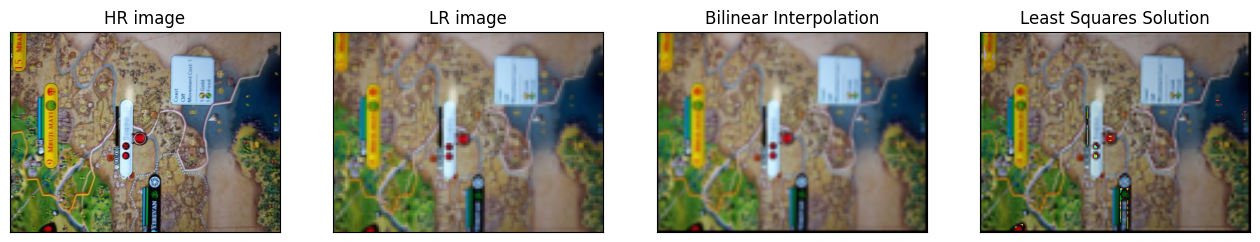

In [25]:
sigma = 0.0
hr_image = next(iter(trainloader))
A = underSamplingOperator(4)
# WD- High resolution image gets undersampled
testLR = A.forward(hr_image.cuda())
testLR = testLR+sigma*torch.randn(testLR.shape).cuda()
testHR = A.backward(testLR)
cg = cg_block(100,1e-2)
lhs = lambda x:A.normal(x)+0.01*x
# WD- Solve using conjugate gradient
out = cg(lhs,testHR,testHR).detach().cpu()
testHR = A.factor**2*A.backward(testLR)
# WD- Display images
fig, ax = plt.subplots(1,4,figsize=(16,4))
img = np.transpose(np.asarray(hr_image[0]),(1,2,0))
s=ax[0].imshow(np.uint8(255*img))
s=ax[0].set_title('HR image')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

img = np.transpose(np.asarray(testLR[0].cpu()),(1,2,0))
s=ax[1].imshow(np.uint8(255*img))
s=ax[1].set_title('LR image')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

img = np.transpose(np.asarray(testHR[0].cpu()),(1,2,0))
s=ax[2].imshow(np.uint8(255*img))
s=ax[2].set_title('Bilinear Interpolation')
s=ax[2].get_xaxis().set_visible(False)
s=ax[2].get_yaxis().set_visible(False)

img = np.transpose(np.asarray(out[0].cpu()),(1,2,0))
s=ax[3].imshow(np.uint8(255*img))
s=ax[3].set_title('Least Squares Solution')
ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)


## MoDL block

MoDL solves the optimization problem
$$\mathbf x^* = \arg \min_{\mathbf x} \|\mathbf A\mathbf x-\mathbf y\|^2 + \lambda \|\mathbf x-\mathcal D_{w}(\mathbf x)\|^2.$$
Here, $\mathcal D_{w}(\mathbf x)$ is a CNN denoiser.

The algorithm is solved using alternating minimization, which alternates between the following steps

$$\mathbf z_n = \mathcal D_{w}(\mathbf x_n)---(1)$$

$$\mathbf x_{n+1} =  \arg \min_{\mathbf x} \|\mathbf A\mathbf x-\mathbf y\|^2 + \lambda \|\mathbf x-\mathbf z_n\|^2---(2)$$
The above algorithm is unrolled for nUnroll steps. The output of the network is $\mathbf x_{nunroll}$, while its input is $\mathbf x_0$. It is a common practice to feed the least squares solution $\mathbf x_{0} =  \left(\mathbf A^T \mathbf A\right)^{-1}\left(\mathbf A^T\mathbf b\right)$ as the initialization.

Step (2) is implemented using a conjugate gradient algorithm with 5 iterations with an initialization of $\mathbf x_0=\mathbf x_n$, which solves

$$\mathbf x_{n+1} =  \left(\mathbf A^T \mathbf A + \lambda \mathbf I\right)^{-1}\left(\mathbf A^T\mathbf b + \lambda\mathbf z_n\right)$$


In [29]:
class modl(nn.Module):

    def __init__(self, A,net,lam,nCGiter=5,tol=1e-4,nUnrolls=3)-> None:
        super(modl, self).__init__();

        # Feature extraction layer.
        self.A = A
        self.net = net
        self.lam = torch.tensor(lam,dtype=torch.float64).requires_grad_(True)
        self.cg = cg = cg_block(nCGiter,tol)
        self.nUnrolls = nUnrolls

    def forward(self, Atb:torch.Tensor,x0:torch.Tensor ) -> torch.Tensor:

        x = x0.clone()

        lhs = lambda x: A.normal(x)+ self.lam*x

        for i in range(self.nUnrolls):
            # WD- Calculating the step 1 of the minimization. z = A.T * b + lam * z
            z =  Atb+ self.lam*self.net(x)
            # WD- Calculating the step 2 of the minimization. x = (A.T * A + lam * I)^-1 * z
            x = self.cg(lhs,z,x0=x)

        return x


## Training the model

In [30]:
# WD- Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# WD- Define an undersampling operator
A = underSamplingOperator(4)
# WD- Define a super resolution convolutional neural network
net = SRCNN(32,upSamplingFactor=1).to(device)
# WD- Set max unrolls
maxUnrolls = 4
# WD- Define model
model = modl(A,net,0.1,nUnrolls=maxUnrolls)
# WD- Define loss function
lossfn = torch.nn.L1Loss(reduction='mean')

optimizer = optim.SGD([
    # WD- Network params (weights and biases)
                {'params': model.net.parameters(),'lr': 1e-3},
    # WD- Optimization problem lambda
                {'params':model.lam,'lr': 1e-7}
            ], lr=1e-2, momentum=0.9)

# WD- Train for 150 iterations
for epoch in range(150):
    epochloss = 0

    for hr_image in trainloader:
        x = int(hr_image.shape[2]/A.factor)*A.factor
        y = int(hr_image.shape[3]/A.factor)*A.factor
        hr_image = hr_image[:,:,:x,:y]
        # WD- High resolution image gets undersampled
        testLR = A.forward(hr_image.cuda() )
        # WD- Add noise
        testLR = testLR+sigma*torch.randn(testLR.shape).cuda()
        # WD- Upsampling
        testHR = A.backward(testLR)
        # WD- Initial guess set by conjugate gradient method
        x0 = cg(lhs,testHR.cuda(),testHR.cuda()).detach().cpu()
        # WD- Uundersampled image trains model
        out = model(testHR.to(device),x0.to(device))
        # WD- Cost calculation
        cost =lossfn(out,hr_image.to(device))
        # WD- Gradient reset
        optimizer.zero_grad()
        # WD- Model updated
        cost.backward()
        optimizer.step()
        # WD- Cost added up
        epochloss += cost
    if np.mod(epoch,10)==0:
        # WD- Print loss and trained image, every 10 rounds of training
        print(epochloss.item()/dataset.__len__(),'lam=',model.lam.item())

        # WD- Display the images
        fig, ax = plt.subplots(1,4,figsize=(16,4))
        img = np.transpose(np.asarray(hr_image[0]),(1,2,0))
        s=ax[0].imshow(np.uint8(255*img))
        s=ax[0].set_title('HR image')
        ax[0].get_xaxis().set_visible(False)
        ax[0].get_yaxis().set_visible(False)

        img = np.transpose(np.asarray(testLR[0].cpu()),(1,2,0))
        s=ax[1].imshow(np.uint8(255*img))
        s=ax[1].set_title('LR image')
        ax[1].get_xaxis().set_visible(False)
        ax[1].get_yaxis().set_visible(False)

        cgresult = cg(lhs,testHR,testHR).detach().cpu()
        img = np.transpose(np.asarray(cgresult[0]),(1,2,0))
        s=ax[2].imshow(np.uint8(255*img))
        s=ax[2].set_title('CG Result')
        s=ax[2].get_xaxis().set_visible(False)
        s=ax[2].get_yaxis().set_visible(False)

        img = np.transpose(np.asarray(out[0].detach().cpu()),(1,2,0))
        s=ax[3].imshow(np.uint8(255*img))
        s=ax[3].set_title('MoDL')
        ax[3].get_xaxis().set_visible(False)
        ax[3].get_yaxis().set_visible(False)
        #if(nUnrolls<maxUnrolls):
        #    nUnrolls = nUnrolls+1

        plt.show()



Output hidden; open in https://colab.research.google.com to view.

## Testing the model

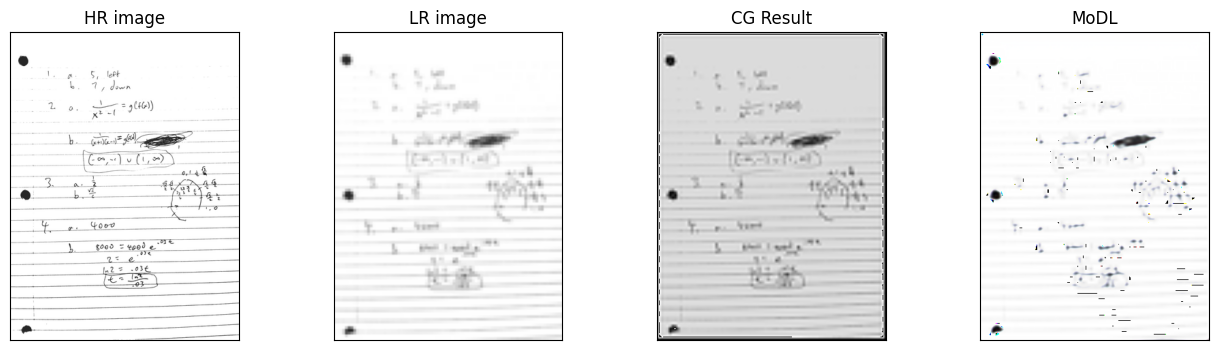

In [31]:
# WD- Get testing data
hr_image = next(iter(testloader))
x = int(hr_image.shape[2]/A.factor)*A.factor
y = int(hr_image.shape[3]/A.factor)*A.factor
hr_image = hr_image[:,:,:x,:y]
# WD- Undersample the testing image
testLR = A.forward(hr_image.cuda() )
testLR = testLR+sigma*torch.randn(testLR.shape).cuda()
testHR = A.backward(testLR)
# WD- Initial guess with CG
x0 = cg(lhs,testHR.cuda(),testHR.cuda()).detach().cpu()
# WD- Model applied to undersampled image
out = model(testHR.to(device),x0.to(device)).detach().cpu()

# WD- Display results
fig, ax = plt.subplots(1,4,figsize=(16,4))
img = np.transpose(np.asarray(hr_image[0]),(1,2,0))
s=ax[0].imshow(np.uint8(255*img))
s=ax[0].set_title('HR image')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

img = np.transpose(np.asarray(testLR[0].cpu()),(1,2,0))
s=ax[1].imshow(np.uint8(255*img))
s=ax[1].set_title('LR image')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

cgresult = cg(lhs,testHR,testHR).detach().cpu()
img = np.transpose(np.asarray(cgresult[0]),(1,2,0))
s=ax[2].imshow(np.uint8(255*img))
s=ax[2].set_title('CG Result')
s=ax[2].get_xaxis().set_visible(False)
s=ax[2].get_yaxis().set_visible(False)

img = np.transpose(np.asarray(out[0].detach().cpu()),(1,2,0))
s=ax[3].imshow(np.uint8(255*img))
s=ax[3].set_title('MoDL')
ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)

plt.show()


## Saving the model

In [32]:
model_path = '/content/drive/MyDrive/Capstone_ML_Project/MoDL-app-in-blurred-img/saved_models/model2.pth'

# Save the entire model
torch.save(model, model_path)

## Loading the model

In [37]:

# Specify the file path where your model is saved
model_path = '/content/drive/MyDrive/Capstone_ML_Project/MoDL-app-in-blurred-img/saved_models/model2.pth'

# Load the model
loaded_model = torch.load(model_path)


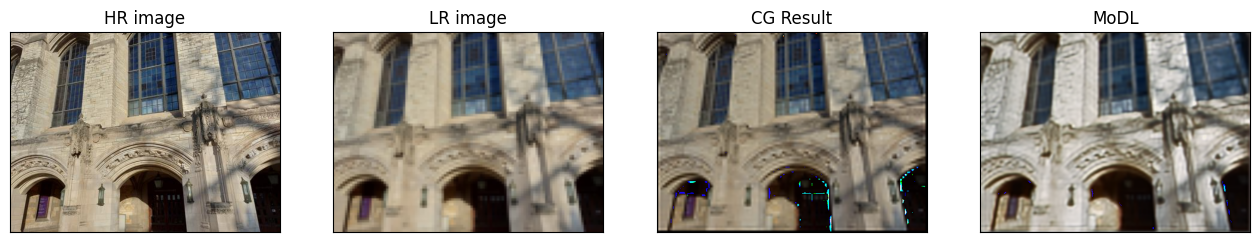

In [39]:
# WD- Get testing data
hr_image = next(iter(testloader))
x = int(hr_image.shape[2]/A.factor)*A.factor
y = int(hr_image.shape[3]/A.factor)*A.factor
hr_image = hr_image[:,:,:x,:y]
# WD- Undersample the testing image
testLR = A.forward(hr_image.cuda() )
testLR = testLR+sigma*torch.randn(testLR.shape).cuda()
testHR = A.backward(testLR)
# WD- Initial guess with CG
x0 = cg(lhs,testHR.cuda(),testHR.cuda()).detach().cpu()
# WD- Model applied to undersampled image
out = loaded_model(testHR.to(device),x0.to(device)).detach().cpu()

# WD- Display results
fig, ax = plt.subplots(1,4,figsize=(16,4))
img = np.transpose(np.asarray(hr_image[0]),(1,2,0))
s=ax[0].imshow(np.uint8(255*img))
s=ax[0].set_title('HR image')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

img = np.transpose(np.asarray(testLR[0].cpu()),(1,2,0))
s=ax[1].imshow(np.uint8(255*img))
s=ax[1].set_title('LR image')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

cgresult = cg(lhs,testHR,testHR).detach().cpu()
img = np.transpose(np.asarray(cgresult[0]),(1,2,0))
s=ax[2].imshow(np.uint8(255*img))
s=ax[2].set_title('CG Result')
s=ax[2].get_xaxis().set_visible(False)
s=ax[2].get_yaxis().set_visible(False)

img = np.transpose(np.asarray(out[0].detach().cpu()),(1,2,0))
s=ax[3].imshow(np.uint8(255*img))
s=ax[3].set_title('MoDL')
ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)

plt.show()
